In [136]:
import pandas as pd
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [137]:
df_fuji = pd.read_csv("../../../DataSet/Fuji/fuji.csv")
# df_fuji.info()

In [138]:
df_fuji["Date"] = pd.to_datetime(df_fuji["Date"], format="%d/%m/%Y")
df_fuji.sort_values(by="Date", inplace=True)
df_fuji

,Date,Fuji
0,2015-01-04,24964
1,2015-01-11,10998
2,2015-01-18,6342
3,2015-01-25,7556
4,2015-02-01,36532
...,...,...
164,2018-02-25,7519
165,2018-03-04,1836
166,2018-03-11,2280
167,2018-03-18,6655


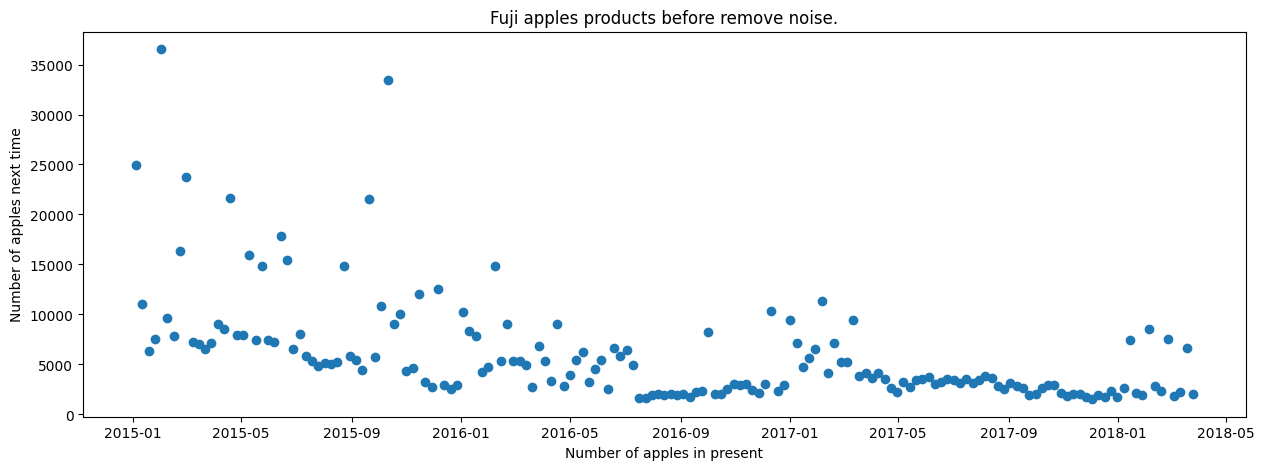

In [139]:
plt.figure(figsize=(15,5))
plt.title("Fuji apples products before remove noise.")
plt.scatter(df_fuji["Date"], df_fuji["Fuji"])
plt.xlabel("Number of apples in present")
plt.ylabel("Number of apples next time")
plt.show()

In [140]:
df_fuji = df_fuji[df_fuji["Fuji"] <= 10000]
df_fuji

,Date,Fuji
2,2015-01-18,6342
3,2015-01-25,7556
5,2015-02-08,9647
6,2015-02-15,7840
9,2015-03-08,7206
...,...,...
164,2018-02-25,7519
165,2018-03-04,1836
166,2018-03-11,2280
167,2018-03-18,6655


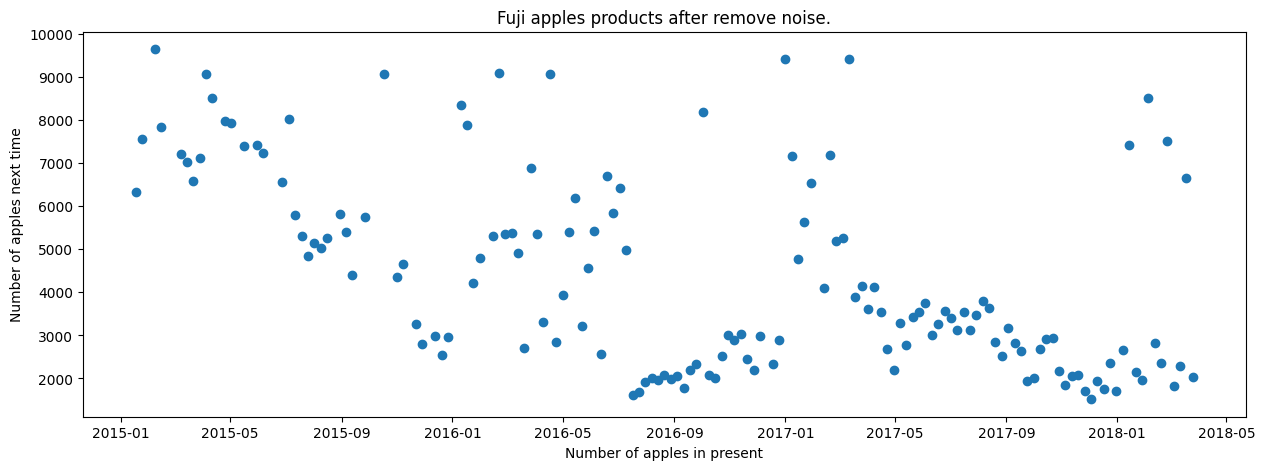

In [141]:
plt.figure(figsize=(15,5))
plt.title("Fuji apples products after remove noise.")
plt.scatter(df_fuji["Date"], df_fuji["Fuji"])
plt.xlabel("Number of apples in present")
plt.ylabel("Number of apples next time")
plt.show()

In [142]:
def writeEvaluate(model, mae:np.float64, mse:np.float64, r2:np.float64, filename):
    df = pd.read_csv(filename)
    row_index = df.index.get_loc(df.loc[df['Model'] == model].index[0])
    df.at[row_index,'Mae'] = mae
    df.at[row_index,'Mse'] = mse
    df.at[row_index,'R2'] = r2

    df.to_csv(filename,encoding='utf-8', sep=',', index=False)

In [143]:
def findBestRandomState(r,t, x, y):
    random = 0
    a = 1000000

    model = RegressorChain(GradientBoostingRegressor())
    for _ in range(r,t):
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=_)
        model.fit(x_train[:,1:], y_train[:,1:])

        y_predict = model.predict(x_test[:,1:])
        if (buff := mean_absolute_error(y_test[:, 1:], y_predict)) < a:
            a = buff
            random = _
            
    print(a, random)

Function Create X Sequence to Prdict 1

In [144]:
def createSequenceToOneDataSet(r, data:pd.DataFrame):  # Create Sequence DataSet
    df = data.copy()
    i = 1
    
    while i < r:
        df[f'x{i}'] = df['Fuji'].shift(-i)
        i += 1

    if i == r:
        df['y'] = df['Fuji'].shift(-i)

    df = df.dropna(axis=0)
    return df

DataSet for Predict y by Use Sequence X

In [145]:
df = createSequenceToOneDataSet(5, df_fuji)
df

,Date,Fuji,x1,x2,x3,x4,y
2,2015-01-18,6342,7556.0,9647.0,7840.0,7206.0,7018.0
3,2015-01-25,7556,9647.0,7840.0,7206.0,7018.0,6590.0
5,2015-02-08,9647,7840.0,7206.0,7018.0,6590.0,7120.0
6,2015-02-15,7840,7206.0,7018.0,6590.0,7120.0,9060.0
9,2015-03-08,7206,7018.0,6590.0,7120.0,9060.0,8506.0
...,...,...,...,...,...,...,...
159,2018-01-21,2157,1972.0,8511.0,2816.0,2363.0,7519.0
160,2018-01-28,1972,8511.0,2816.0,2363.0,7519.0,1836.0
161,2018-02-04,8511,2816.0,2363.0,7519.0,1836.0,2280.0
162,2018-02-11,2816,2363.0,7519.0,1836.0,2280.0,6655.0


In [146]:
x = np.array(df.drop(columns='y'))
y = np.array(df.drop(columns=['Fuji','x1','x2','x3','x4']))

# scaler = StandardScaler()
# scaler.fit(x)
# x = scaler.transform(x)
# scaler.fit(y.reshape(-1,1))
# y = scaler.transform(y.reshape(-1,1))



# findBestRandomState(900000,1000000,x, y)
# seed 23129 MAE: 746.9639053577858
# seed 192756 MAE: 709.9862772451042
# seed 261286 MAE: 742.5446013024817 200000,300001
# seed 328148 MAE: 724.2193521779465 300000,400001
# seed 400299 MAE: 744.5387942353359 400000,450001
# seed 476779 MAE: 796.4728903000357 450000,500001
# seed 930734 MAE: 756.4441261220218 900000,1000000



x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=930734)

x_train = np.array(sorted(x_train, key=lambda x: x[0]))
x_test = np.array(sorted(x_test, key=lambda x: x[0]))
y_train = np.array(sorted(y_train, key=lambda x: x[0]))
y_test = np.array(sorted(y_test, key=lambda x: x[0]))


In [147]:
ml = RegressorChain(GradientBoostingRegressor(learning_rate=0.07, criterion='friedman_mse', max_leaf_nodes=16, max_features=6))
ml.fit(x_train[:, 1:], y_train[:, 1:])

RegressorChain(base_estimator=GradientBoostingRegressor(learning_rate=0.07,
                                                        max_features=6,
                                                        max_leaf_nodes=16))

In [148]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [149]:
y_predict = ml.predict(x_test[:, 1:])

mae = mean_absolute_error(y_test[:, 1:], y_predict) # Best MAE: 655.3718564288306
mse = mean_squared_error(y_test[:, 1:], y_predict)
r2 = r2_score(y_test[:, 1:], y_predict)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Square Error: {mse}")
print(f"R2 score: {r2}")

writeEvaluate("GradientBoosting",mae,mse,r2,"evaluate.csv")

Mean Absolute Error: 655.3718564288306
Mean Square Error: 975837.5449477811
R2 score: 0.7395240858364617


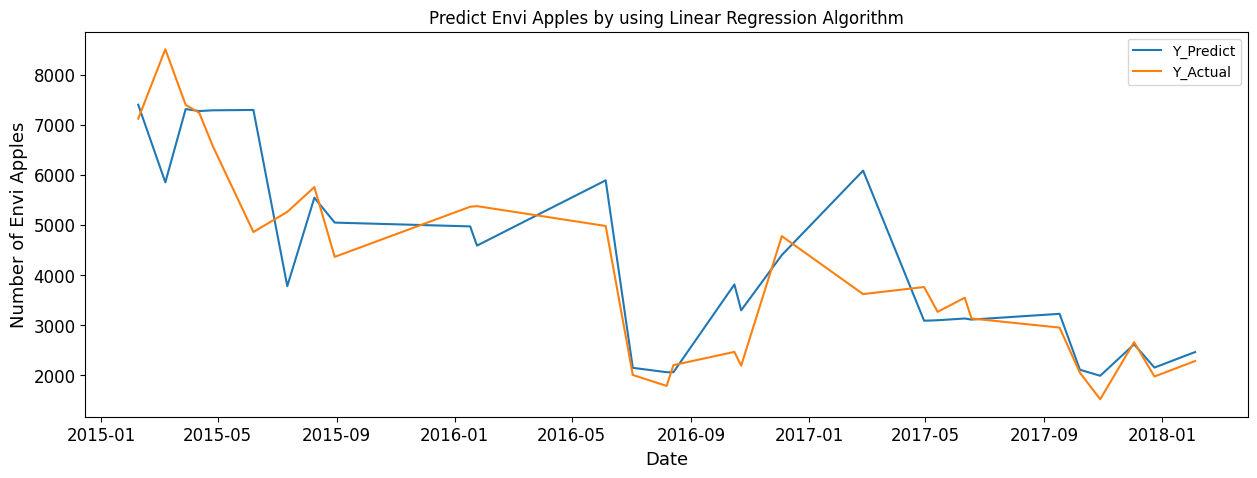

In [150]:
plt.figure(figsize=(15, 5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(x_test[:, :1], y_predict, label="Y_Predict")
plt.plot(x_test[:,:1], y_test[:, 1:], label="Y_Actual")
plt.xlabel("Date", fontsize=13)
plt.ylabel("Number of Envi Apples", fontsize=13)
plt.title("Predict Envi Apples by using Linear Regression Algorithm")
plt.legend()
plt.show()